*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users. 

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

In [12]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2020-11-14 17:24:51--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip      [   <=>              ]  24.88M  53.7MB/s    in 0.5s    

2020-11-14 17:24:51 (53.7 MB/s) - ‘book-crossings.zip’ saved [26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [3]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [4]:
# add your code here - consider creating a new cell for each section of code

###### Huge thanks to Kevin Liao for his [knn movie recommender article](https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea), which I have relied on heavily.

In [53]:
# First let's see how many times each isbn appears in our ratings dataset

df_ratings['isbn'].value_counts()

0971880107    2502
0316666343    1295
0385504209     883
0060928336     732
0312195516     723
              ... 
0486229734       1
042505850        1
0060526491       1
0312303777       1
1558852689       1
Name: isbn, Length: 340556, dtype: int64

In [ ]:
# We can split out the books that appear rated fewer than 100 times

In [55]:
bins = pd.IntervalIndex.from_tuples([(0, 99), (99, 2502)])
cuts = pd.cut(pd.Series(df_ratings['isbn'].value_counts().values), bins).value_counts()
cuts

(0, 99]       339825
(99, 2502]       731
dtype: int64

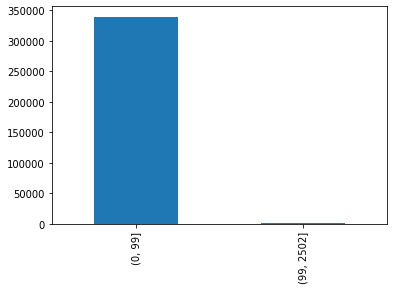

In [57]:
# this shows how sadly few books in our dataset have enough ratings to keep for training our model.
# hopefully people get to recommending more books before long!
cuts.plot(kind='bar')

In [58]:
keep_isbns = df_ratings['isbn'].value_counts()[df_ratings['isbn'].value_counts() >= 100].index
df_keep_isbns = df_ratings[df_ratings['isbn'].isin(keep_isbns)]

In [59]:
# and doing the same for users
df_ratings['user'].value_counts()

11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
158698        1
17920         1
277135        1
275086        1
187812        1
Name: user, Length: 105283, dtype: int64

In [62]:
# one prolific book rater has reviews for over 13000 books!
user_bins = pd.IntervalIndex.from_tuples([(0, 199), (199, 13602)])
user_cuts = pd.cut(pd.Series(df_ratings['user'].value_counts().values), user_bins).value_counts()
user_cuts

(0, 199]        104378
(199, 13602]       905
dtype: int64

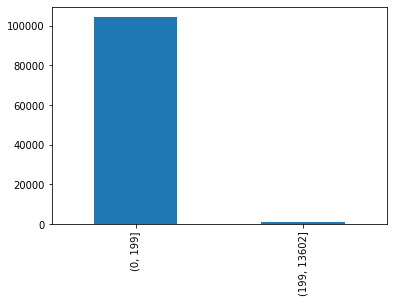

In [63]:
user_cuts.plot(kind='bar')

In [64]:
keep_users = df_ratings['user'].value_counts()[df_ratings['user'].value_counts() >= 200].index
df = df_keep_isbns[df_keep_isbns['user'].isin(keep_users)]

In [66]:
# luckily, our dataset still has almost 50k data points
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49781 entries, 1456 to 1147441
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   user    49781 non-null  int32  
 1   isbn    49781 non-null  object 
 2   rating  49781 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 1.1+ MB


In [67]:
# only keep reviews for which we have a corresponding entry in df_books
df = df[df['isbn'].isin(df_books['isbn'].values)]

In order to utilize [collaborative item-based filtering](https://en.wikipedia.org/wiki/Item-item_collaborative_filtering) for this recommender, we pivot our dataframe to have a row for each isbn, a column for each user, and put the rating each user gave each isbn as the value at their intersection.

We replace any NaN's (indicating a user hasn't reviewed that isbn) with 0's so we can pass the data to our model.

In [70]:
isbn_user_ratings = df.pivot(
    index='isbn',
    columns='user',
    values='rating'
).fillna(0)
isbn_user_ratings.head()

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,6543,6563,6575,7158,7286,7346,7915,8067,8245,8681,8936,9856,10447,10819,11601,11676,11993,12538,12824,12982,13082,13273,13552,13850,14422,14521,15408,15418,15957,16106,...,264317,264321,264637,265115,265313,265595,265889,266056,266226,266753,266865,266866,267635,268030,268032,268110,268330,268622,268932,269566,269719,269728,269890,270713,270820,271195,271284,271448,271705,273979,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
isbn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
002542730X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
0060008032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060096195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006016848X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060173289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This leaves us with a very sparse matrix -- we already know that most users do not have a rating for most books.
To handle this sparse matrix efficiently, we can convert it to a csr_matrix (compressed sparse row) from scipy.

In [71]:
isbn_user_ratings_sparse = csr_matrix(isbn_user_ratings)

In [72]:
# later, we'll want to be able to get a book's index in our df_books dataset by it's title, so we make a map:
title_to_index = {
    book: i for i, book in enumerate(list(df_books.set_index('isbn').loc[isbn_user_ratings.index].title))
}

In [73]:
# we'll also want the reverse soon
index_to_title = {
    v: k for k, v in title_to_index.items()
}

Because our matrix is so sparse, using the default Euclidean distance metric in our model probably won't work. Instead, we'll use cosine similarity.

In [75]:
# instantiate and train the model
model = NearestNeighbors(5, algorithm='brute', metric='cosine')
model.fit(isbn_user_ratings_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

Finally, to make a prediction given a book's title, we


1.   Get the index of that title from our title_to_index mapping
2.   Get the distances and indices of the 6 nearest neighbors to that book from our model. The first will always be the index of the book we're searching for
3. Get the titles for all of those books from our index_to_title mapping
4. Merge the title's list to the distances list, and ignore the first item (the book we asked for)
5. Reverse the list so it's in order of decreasing distance



In [77]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  idx = title_to_index[book]
  dists, idxs = model.kneighbors(isbn_user_ratings_sparse[idx], 6)
  titles = [index_to_title[idx] for idx in idxs[0]]
  recs = list(zip(titles, dists[0]))[1:]
  recs.reverse()
  return [book, recs]

Use the cell below to test your function. The `test_book_recommendation()` function will inform you if you passed the challenge or need to keep trying.

In [78]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You havn't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [("I'll Be Seeing You", 0.8016211), ('The Weight of Water', 0.77085835), ('The Surgeon', 0.7699411), ('I Know This Much Is True', 0.7677075), ('The Lovely Bones: A Novel', 0.7234864)]]
You passed the challenge! 🎉🎉🎉🎉🎉
